# Projet ingénieurie des réseaux


In [52]:
import pandas as pd
import json

Fonctions auxiliaires pour parser et plot

In [53]:
def parse_log(log: str):
    # load json
    with open(log, 'r') as f:
        data = json.load(f)
    # infos
    host = data['start']['connected'][0]['local_host']
    remote_host = data['start']['connected'][0]['remote_host']
    remote_port = data['start']['connected'][0]['remote_port']
    protocol = data['start']['test_start']['protocol']
    start = data['start']['timestamp']['timesecs']
    # save bits_per_second
    bps = {}
    for ival in data['intervals']:
        stream = ival['streams'][0]
        ival_start = int(start + stream['end'])
        bps[ival_start] = stream['bits_per_second']
    # return series
    series = pd.Series(
        bps,
        name=rf"{host} $\rightarrow$ {remote_host}:{remote_port}/{protocol}")
    return series


def get_df(*logs: str):
    df = pd.DataFrame()
    # concat series
    for log in logs:
        series = parse_log(log)
        df = pd.concat([df, series.to_frame()], axis=1)
    return df


def plot(df: pd.DataFrame):
    df = df.sort_index()
    df.index -= df.index.min()
    df /= 1e6
    df.plot(xlabel='t (s)', ylabel='bw (Mbps)', grid=True, figsize=(7, 5))


iPerf3 serveur -> client

`iperf3 -c 100.0.0.2 -p 5201-5203 -i 1 -t 30 -b 0 -R`\
`-u` pour UDP\
`-J` pour JSON

## TCP + UDP sans QoS


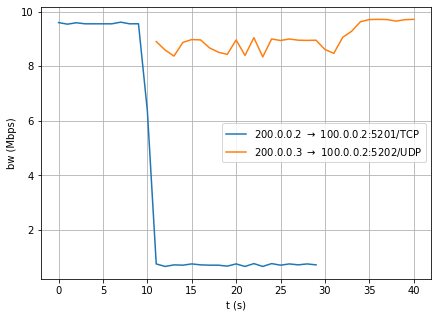

In [54]:
df = get_df('./data/no_qos/tcp_udp/tcp.json', './data/no_qos/tcp_udp/udp.json')
plot(df)

UDP mange TCP comme prévu

## Instauration de QoS sur `tc`

5201: Expedited Forwarding 8mbps

5202: Assured Forwarding (1mbps min)

5203: Best effort


### 3 flux tcp

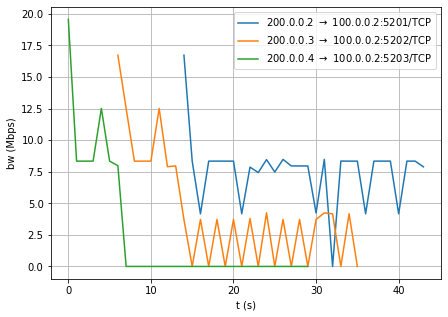

In [55]:
df = get_df('./data/qos/diffserv1/a.json', './data/qos/diffserv1/b.json', './data/qos/diffserv1/c.json')
plot(df)